## COVID-19 Data Tracker

This Notebook contains code for tracking how the coronavirus is spreading around the world. The "World COVID-19 Daily Cases with Basemap" dataset by China Data Lab [1] is used for this project.

The following essential metrics are tracked:
- Time-varying estimate of the effective reproduction number $R_t$
- Daily confirmed cases 
- Daily deaths attributed to COVID-19
- Daily recoveries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import epyestim.covid19 as covid19

### Loading and Preprocessing Data

In [2]:
def get_df(path, transform=True):
    df = pd.read_csv(path)
    df = df.T
    
    headers = df.iloc[0]
    new_df  = pd.DataFrame(df.values[1:], columns=headers, index=pd.DatetimeIndex(df.index[1:]))
    new_df.columns.name = ""
    new_df.index.name = "Date"
    if transform:
        new_df = new_df.diff()
        new_df.fillna(value=0, inplace=True)
        new_df[new_df < 0] = 0 
    return new_df

In [3]:
confirmed = get_df("data/data_Confirmed.csv")
print(confirmed.shape)
confirmed.tail()

(388, 192)


,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-08,24,953,225,24,26,17,5154,89,3,1057,...,14138,339,64,0,480,49,612,4,940,106
2021-02-09,25,1239,246,37,51,0,7794,123,11,1197,...,12441,503,42,0,500,14,762,0,1037,123
2021-02-10,18,1143,223,40,47,34,7739,196,8,1469,...,13077,625,33,0,380,27,761,2,963,83
2021-02-11,18,1105,267,39,51,31,7311,180,8,1577,...,13543,476,66,0,352,49,799,1,1025,0
2021-02-12,25,1059,254,36,33,38,7151,154,5,1731,...,15198,574,37,0,431,2,665,2,1083,181


In [4]:
deaths = get_df("data/data_Deaths.csv")
print(deaths.shape)
deaths.tail()

(388, 192)


,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-08,3,12,4,0,0,0,227,6,0,20,...,333,7,0,0,7,0,7,0,16,13
2021-02-09,1,16,6,0,3,1,168,3,0,39,...,1052,9,0,0,7,0,9,0,12,14
2021-02-10,4,15,2,0,9,1,108,4,0,43,...,1002,10,0,0,6,0,12,1,20,11
2021-02-11,1,14,4,0,0,0,200,5,0,24,...,680,8,1,0,7,0,1,0,13,0
2021-02-12,5,14,2,0,3,0,155,3,0,32,...,759,3,0,0,7,0,8,0,17,29


In [5]:
recovered = get_df("data/data_Recovered.csv")
print(recovered.shape)
recovered.tail()

(388, 192)


,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-08,1,684,179,77,56,2,7213,156,8,1249,...,53,701,42,0,450,0,440,0,1494,274
2021-02-09,67,805,186,64,27,0,6143,293,8,1374,...,104,595,45,0,460,0,663,0,1990,464
2021-02-10,24,683,186,58,64,1,5799,236,3,1245,...,68,497,39,0,420,8,578,0,556,182
2021-02-11,146,746,193,49,23,7,8140,265,4,1234,...,103,657,78,0,400,48,467,0,1114,0
2021-02-12,111,881,192,52,76,2,7900,168,4,1271,...,57,540,54,0,442,1,635,2,1313,488


### Time-varying estimate of the effective reproduction number $R_t$

The effective reproduction number is a key indicator of the growth of an epidemic. It is the average number of new infections caused by a single infected individual at time t. 

epyestim [4] estimates the effective reproduction number from time series of reported case numbers of epidemics. It is a Python reimplementation of the method outlined by Huisman et al. [2], making use of the method by Cori et al. [3] to estimate the reproduction number R from infection data, available in the R package EpiEstim [5].

To calculate the effective reproduction number, we need two distributions:
* The generation time distribution
* The distribution of delays from infection to reporting.

For Covid-19, we'll use the default values provided in the epyestim package:
* *Generation time distribution*: we provide the serial interval distribution (mean: 4.3 days) for Covid-19, as used by Flaxman et al., Nature 584, 257–261 (2020). https://doi.org/10.1038/s41586-020-2405-7
* *Delay distribution*: we provide a standard infection to reporting delay distribution (mean: 10.3 days), obtained as a convolution of the incubation time distribution and onset to reporting delay distribution as used by Brauner et al. (2020) preprint: https://www.medrxiv.org/content/10.1101/2020.05.28.20116129v4

In [6]:
si_dist = covid19.generate_standard_si_distribution()
delay_dist = covid19.generate_standard_infection_to_reporting_distribution()

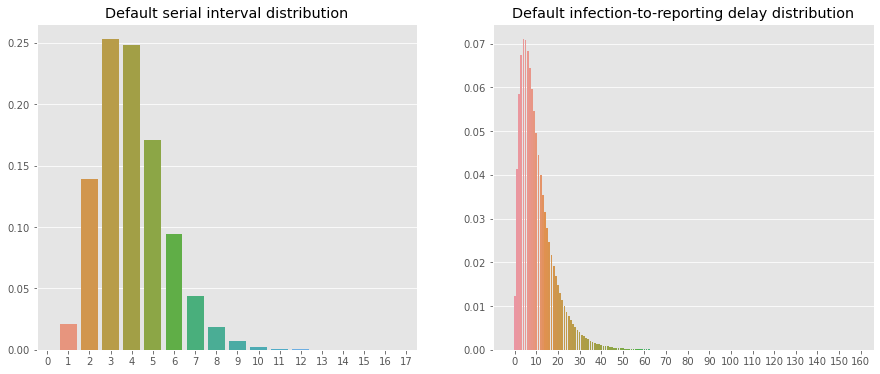

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x=np.array(range(len(si_dist))), y=si_dist, ax=ax0)
ax0.set_title('Default serial interval distribution')

sns.barplot(x=np.array(range(len(delay_dist))), y=delay_dist, ax=ax1)
major_ticks = np.arange(0, len(delay_dist), 10)
ax1.set_xticks(major_ticks)
ax1.set(xlim=(-10, len(delay_dist)))
ax1.set_title('Default infection-to-reporting delay distribution');

### Visualization of $R_t$ and other essential metrics

In [8]:
def plot_r(country):
    R_t = covid19.r_covid(confirmed[country], smoothing_window=21)
    fig, ax = plt.subplots(1,1, figsize=(20, 8))

    R_t.loc[:,'Q0.5'].plot(ax=ax, color='#2c78c9')
    ax.fill_between(R_t.index, 
                    R_t['Q0.025'], 
                    R_t['Q0.975'], 
                    color='#2c78c9', alpha=0.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('$R_{t}$ with 95%-CI')
    ax.set_ylim([0, math.ceil(R_t["Q0.5"].max())])
    ax.axhline(y=1, color="black", alpha=0.7, linestyle='--')
    ax.set_title('Estimate of time-varying effective reproduction number $R_{t}$ (' + country + ')')
    plt.show()

In [9]:
def plot_confirmed(country):
    daily = confirmed[country]
    weekly_mean = daily.rolling(7).mean()
    df = pd.DataFrame({"daily": daily, "weekly_mean": weekly_mean}, index=daily.index)

    fig, ax = plt.subplots(figsize=(20,8))
    ax.bar(x=df.index, height=df["daily"], width=1, color='gray', alpha=0.5)
    ax.plot(df.index, df["weekly_mean"], color='#dd494e', alpha=1, linewidth=2)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('No. of new cases')
    ax.set_ylim([0, math.ceil(df["daily"].max())])
    ax.set_title('Number of new daily cases, with a seven-day moving average (' + country + ')')
    plt.show()

In [10]:
def plot_deaths(country):
    daily = deaths[country]
    weekly_mean = daily.rolling(7).mean()
    df = pd.DataFrame({"daily": daily, "weekly_mean": weekly_mean}, index=daily.index)

    fig, ax = plt.subplots(figsize=(20,8))
    ax.bar(x=df.index, height=df["daily"], width=1, color='gray', alpha=0.5)
    ax.plot(df.index, df["weekly_mean"], color='black', alpha=1, linewidth=2)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('No. of new deaths')
    ax.set_ylim([0, math.ceil(df["daily"].max())])
    ax.set_title('Number of new daily deaths attributed to COVID-19, with a seven-day moving average (' + country + ')')
    plt.show()

In [11]:
def plot_recovered(country):
    daily = recovered[country]
    weekly_mean = daily.rolling(7).mean()
    df = pd.DataFrame({"daily": daily, "weekly_mean": weekly_mean}, index=daily.index)

    fig, ax = plt.subplots(figsize=(20,8))
    ax.bar(x=df.index, height=df["daily"], width=1, color='gray', alpha=0.5)
    ax.plot(df.index, df["weekly_mean"], color='#10ba57', alpha=1, linewidth=2)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('No. of recoveries')
    ax.set_ylim([0, math.ceil(df["daily"].max())])
    ax.set_title('Number of daily recoveries, with a seven-day moving average (' + country + ')')
    plt.show()

In [12]:
def show_plots(country):
    plot_r(country)
    plot_confirmed(country)
    plot_deaths(country)
    plot_recovered(country)

### Coronavirus in Kazakhstan

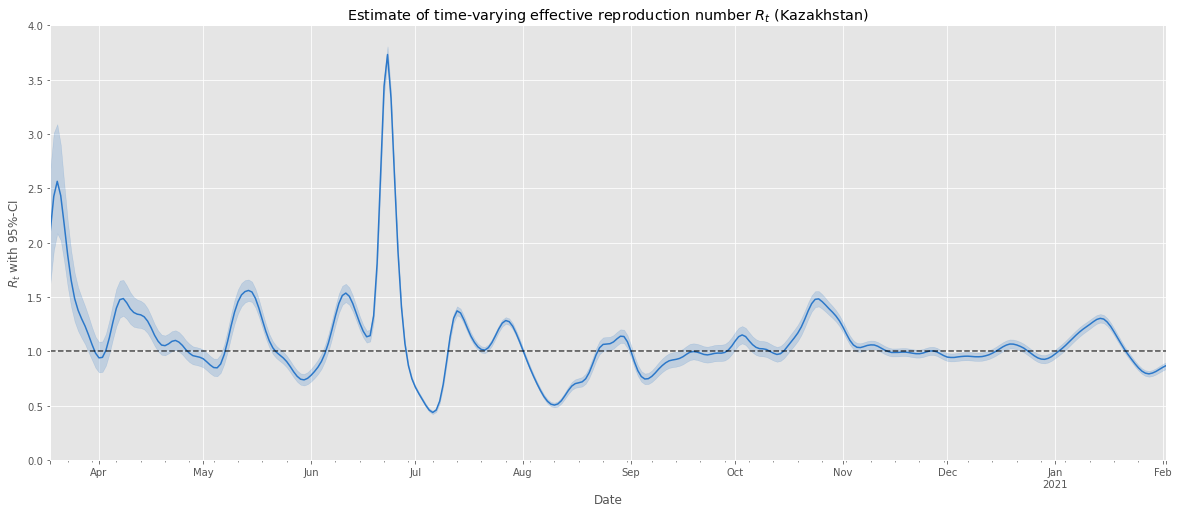

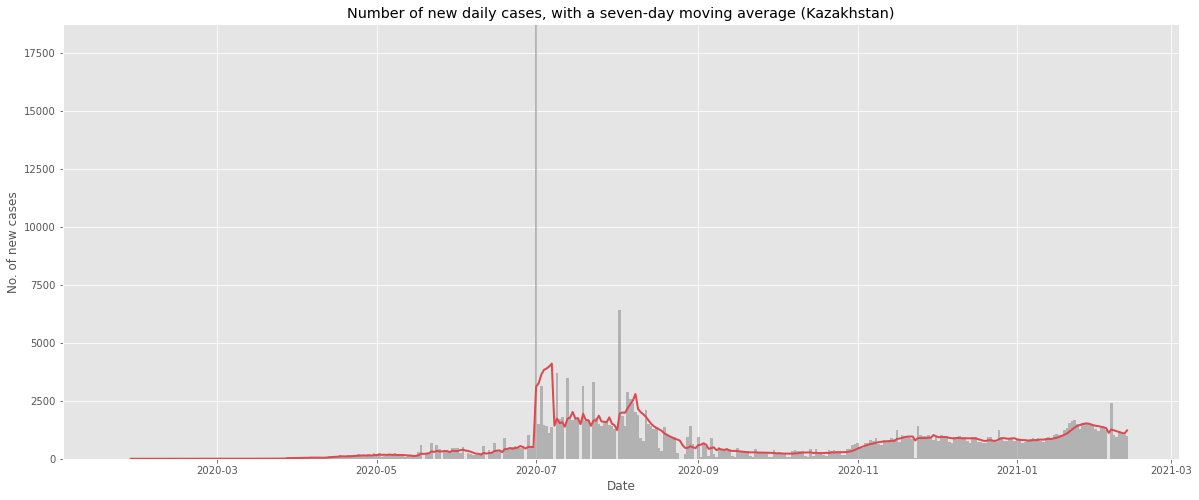

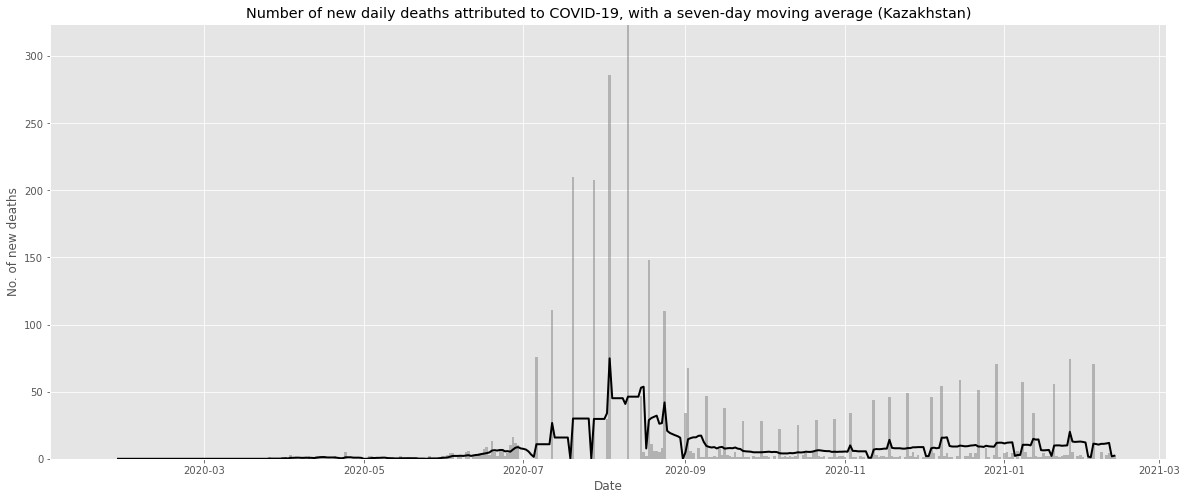

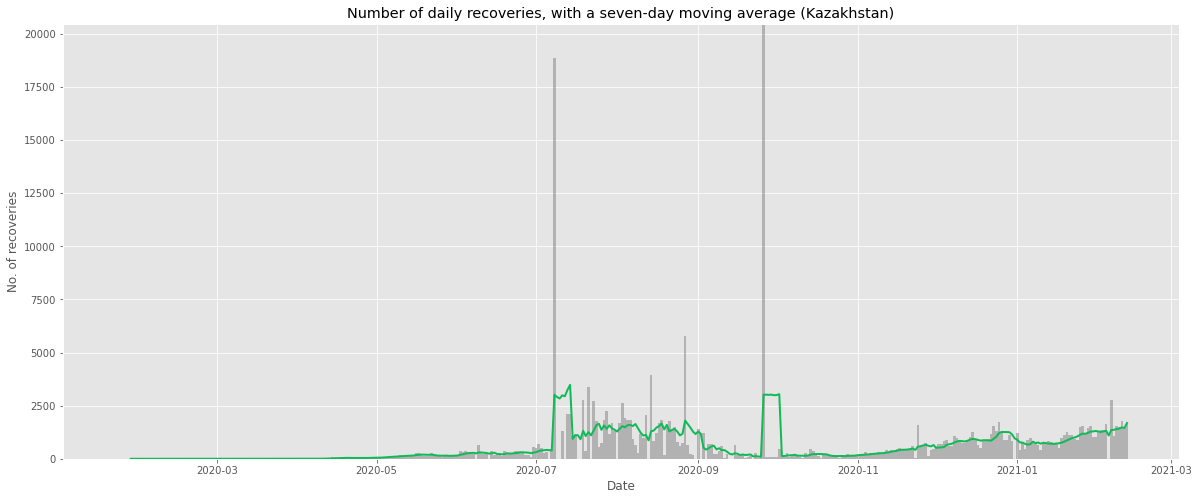

In [13]:
show_plots("Kazakhstan")

### Coronavirus in Russia

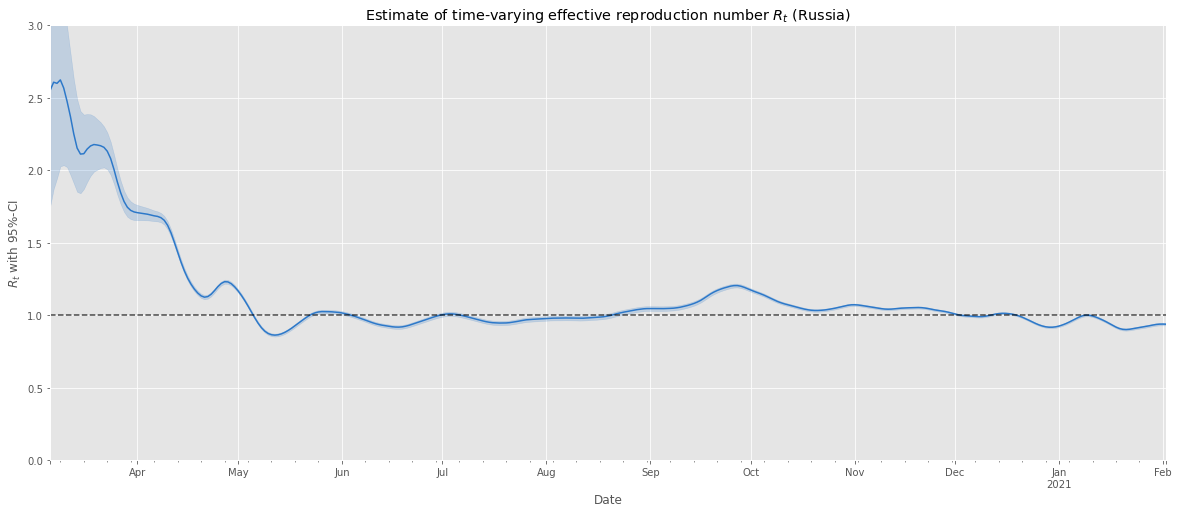

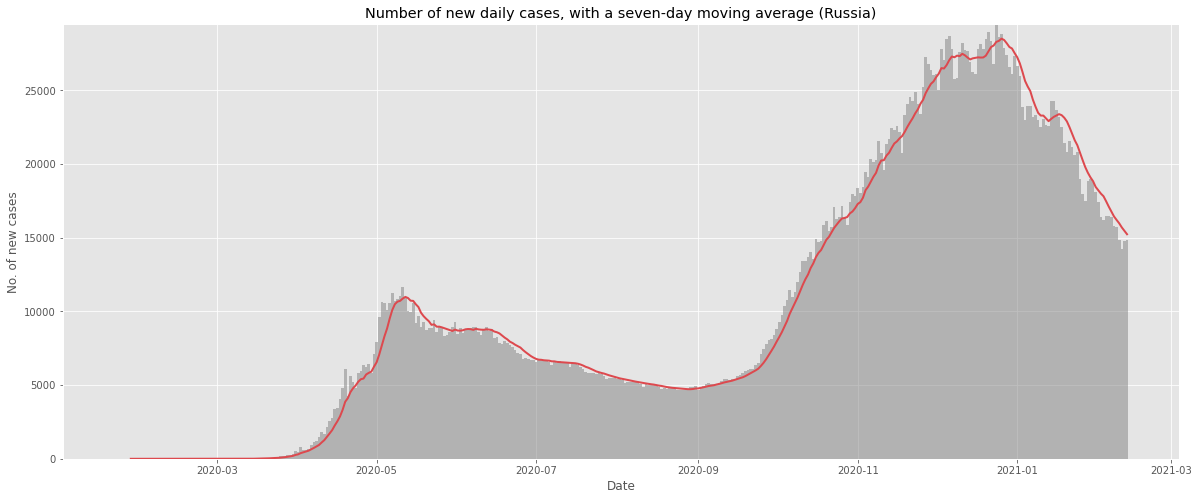

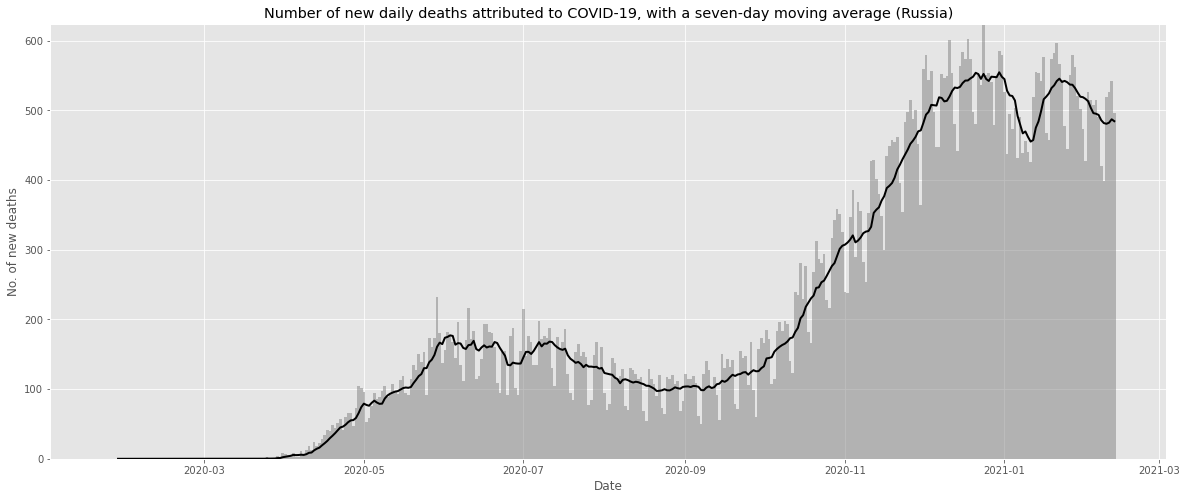

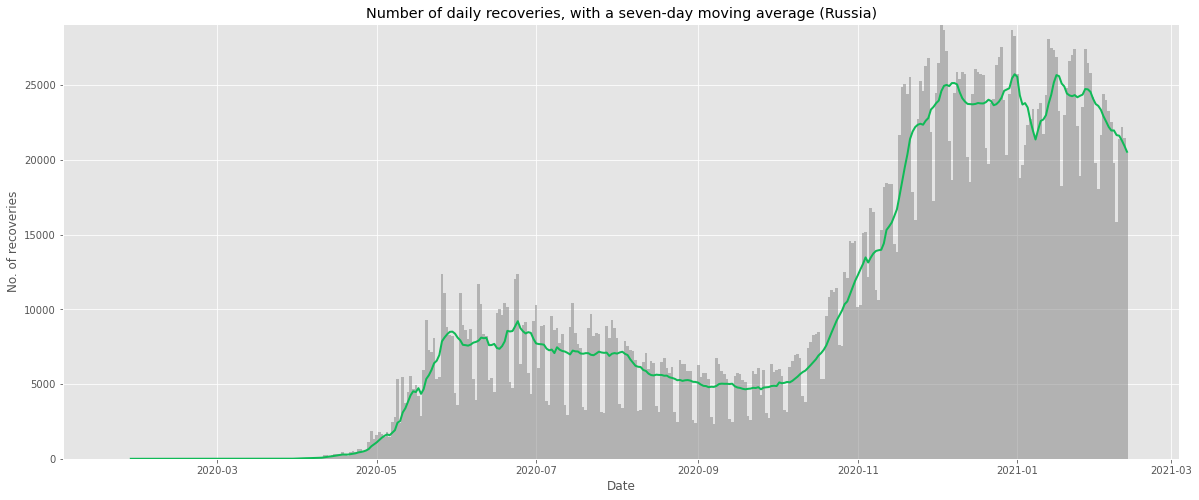

In [14]:
show_plots("Russia")

### References

[1] China Data Lab, 2020, "World COVID-19 Daily Cases with Basemap", https://doi.org/10.7910/DVN/L20LOT, Harvard Dataverse, V39, UNF:6:6YPeKdr6EnCe4EC2s7XIIQ==

[2] Jana S. Huisman, Jeremie Scire, Daniel Angst, Richard Neher, Sebastian Bonhoeffer, Tanja Stadler: A method to monitor the effective reproductive number of SARS-CoV-2 https://doi.org/10.1101/2020.11.26.20239368

[3] Anne Cori, Neil M. Ferguson, Christophe Fraser, Simon Cauchemez: A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, American Journal of Epidemiology, Volume 178, Issue 9, 1 November 2013, Pages 1505–1512, https://doi.org/10.1093/aje/kwt133

[4] epyestim Python Package: https://github.com/lo-hfk/epyestim

[5] EpiEstim CRAN package: https://cran.r-project.org/web/packages/EpiEstim/index.html